# VQ-VAE

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/vishnuja/archive/Training_set.csv" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = load_dataset('csv', data_files=dataset_filepath)

def transform_image(data):
    image = Image.open('/home/vishnuja/archive/train/'+data['filename'])
    data['image'] = data_transforms(image)
    return data

dataset = dataset.map(transform_image)
dataset.set_format(type='torch', columns=['image','label'])

dataloader_butterfly = DataLoader(dataset['train'], batch_size=128, shuffle=True, num_workers=5)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, z_dim=64):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1), # 128x128 -> 64x64
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1), # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(hidden_channels, z_dim, kernel_size=4, stride=2, padding=1), # 32x32 -> 16x16
        )

    def forward(self, x):
        return self.encoder(x) 

class Decoder(nn.Module):
    def __init__(self, out_channels=3, hidden_channels=64, z_dim=64):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_channels, kernel_size=4, stride=2, padding=1), # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1), # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=4, stride=2, padding=1), # 64x64 -> 128x128
            nn.Tanh() 
        )

    def forward(self, x):
        return self.decoder(x) 

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z):
        z_flattened = z.view(-1, self.embedding_dim)
        
        distances = (z_flattened.pow(2).sum(1, keepdim=True)
                     - 2 * z_flattened @ self.embeddings.weight.T
                     + self.embeddings.weight.pow(2).sum(1, keepdim=True).T)
        
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
        z_q = self.embeddings(encoding_indices).view_as(z)
        
        loss = F.mse_loss(z_q.detach(), z) + self.commitment_cost * F.mse_loss(z_q, z.detach())
        
        z_q = z + (z_q - z).detach()
        
        return z_q, loss, encoding_indices

class VQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, z_dim=64, num_embeddings=512, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, z_dim)
        self.decoder = Decoder(in_channels, hidden_channels, z_dim)
        self.quantizer = VectorQuantizer(num_embeddings, z_dim, commitment_cost)

    def forward(self, x):
        z = self.encoder(x)  
        z_q, vq_loss, _ = self.quantizer(z)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqvae = VQVAE().to(device)



In [ ]:

optimizer = torch.optim.Adam(vqvae.parameters(), lr=1e-3)
reconstruction_loss_fn = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    for data in dataloader_butterfly:
        images = data['image'].to(device)
        optimizer.zero_grad()
        
        recon_images, vq_loss = vqvae(images)
        recon_loss = reconstruction_loss_fn(recon_images, images)
        loss = recon_loss + vq_loss

        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Recon Loss: {recon_loss.item():.4f}, VQ Loss: {vq_loss.item():.4f}")


In [ ]:

all_images = []
for data in dataloader_butterfly:
    images = data['image'].to(device)
    all_images.extend(images)

all_images = torch.stack(all_images)
random_indices = random.sample(range(len(all_images)), 100)
selected_images = all_images[random_indices]


generated_images,_=vqvae(selected_images)

num_images = min(100, generated_images.shape[0])

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        if idx < num_images:
            img = generated_images[idx].permute(1, 2, 0).detach().cpu()
            axs[i, j].imshow((img + 1) / 2)
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


![alt text](image-13.png)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Posterior inference
latent_vectors = []
labels = []
vqvae.eval()
for data in dataloader_butterfly:
    images = data['image'].to(device)
    z= vqvae.encoder(images)
    latent_vectors.append(z.view(z.size(0),-1))
    labels.extend(data['label'])
latent_vectors = torch.cat(latent_vectors).detach().cpu().numpy()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    latent_vectors, encoded_labels, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


class LatentCNNClassifier(nn.Module):
    def __init__(self,latent_dim, num_classes):
        super(LatentCNNClassifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256) 
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

latent_dim = X_train.size(1)  # Dimension of the latent vectors
num_classes = len(torch.unique(y_train))  # Number of classes based on labels
classifier = LatentCNNClassifier(latent_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

for epoch in range(250):  
    classifier.train()
    optimizer.zero_grad()
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/250], Loss: {loss.item():.4f}')

classifier.eval()
with torch.no_grad():
    test_outputs = classifier(X_test)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
    print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 40.38%


### Fit GMM on latent vectors

In [ ]:

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=500, covariance_type='diag')
gmm.fit(latent_vectors)

generated_images = []
for i in range(100):
    sample_latent = gmm.sample()[0]
    sample_latent = torch.tensor(sample_latent).view(1, 64, 16, 16).float().to(device)
    with torch.no_grad():
        generated_img = vqvae.decoder(sample_latent)
        generated_images.append(generated_img.squeeze(0).cpu())

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        img = generated_images[i * 10 + j].permute(1, 2, 0)
        axs[i, j].imshow((img + 1) / 2)
        axs[i, j].axis('off')
plt.show()


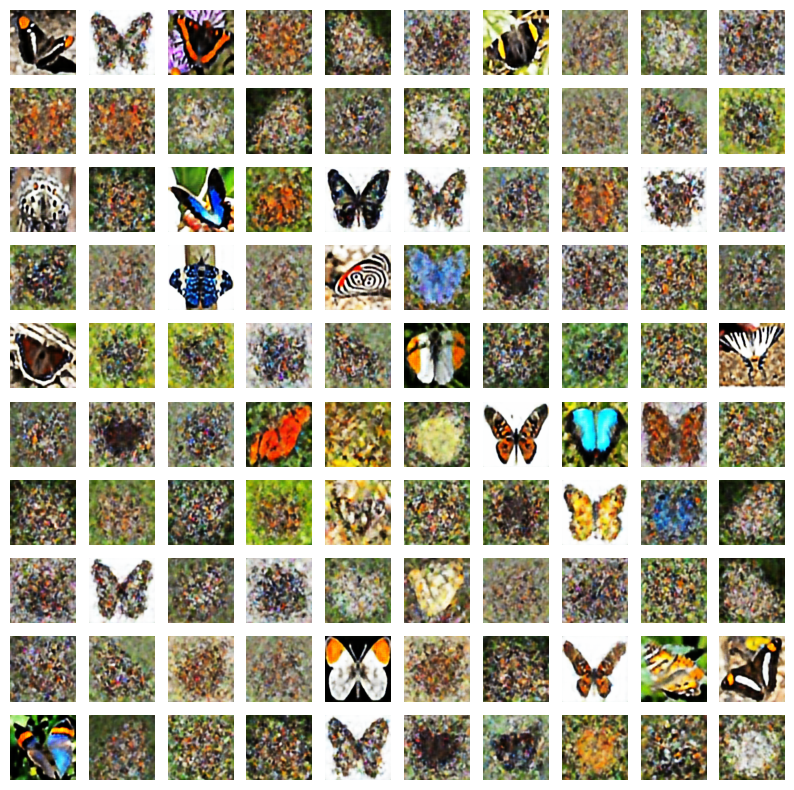

In [ ]:


gmm = GaussianMixture(n_components=500, covariance_type='diag')
gmm.fit(latent_vectors)

generated_images = []
for i in range(700):
    sample_latent = gmm.sample()[0]
    sample_latent = torch.tensor(sample_latent).view(1, 64, 16, 16).float().to(device)
    with torch.no_grad():
        generated_img = vqvae.decoder(sample_latent)
        generated_images.append(generated_img.squeeze(0).cpu())

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        img = generated_images[i * 10 + j].permute(1, 2, 0)
        axs[i, j].imshow((img + 1) / 2)
        axs[i, j].axis('off')
plt.show()


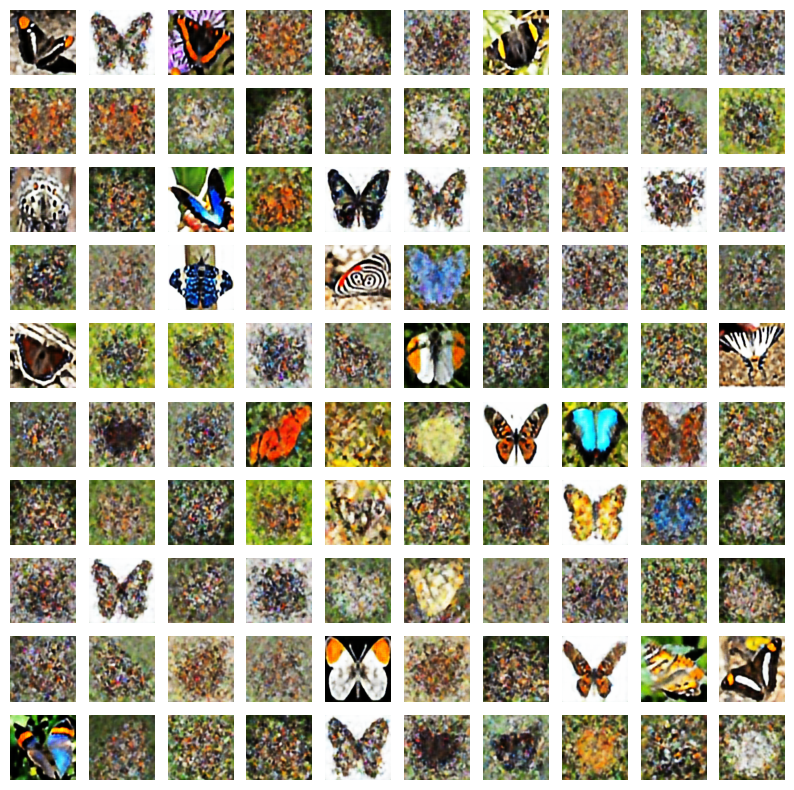